In [1]:
%load_ext autoreload
%autoreload 2

In [61]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from klap.datasets.ground_truth import spherical_eigenvals

SAVE_DIR = Path.home() / 'resrng'

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=8)

In [89]:
def get_average(method, all_runs):
    key = ['n', 'd', 'p', 'kernel', 'kernel_param']
    if method == 'graph_laplacian':
        runs = all_runs[all_runs['graph_laplacian'] > 0]
        key.append('graph_laplacian')
    if method == 'galerkin':
        runs = all_runs[all_runs['graph_laplacian'] == 0]
    elif method == 'graph_laplacian_special':
        runs = all_runs[all_runs['graph_laplacian'] == -1]

    df = runs.groupby(key)['error'].mean().reset_index()
    df['error_std'] = runs.groupby(key)['error'].std().reset_index()['error']
    df['time'] = runs.groupby(key)['time'].mean().reset_index()['time']
    df['time_std'] = runs.groupby(key)['time'].std().reset_index()['time']
    return df


def get_best(df, key):
    return df.loc[df.dropna().groupby(key).error.idxmin()]

In [90]:
# get all runs
# names = ['gaussian']
names = ['exponential', 'gaussian', 'polynomial']

res = []
for name in names:
    save_dir = SAVE_DIR / name
    for task_id in range(1, 501):
        filename = save_dir / f'task_{task_id}.jsonl'
        with open(filename, 'rt') as f:
            res += [json.loads(line) for line in f]
all_runs = pd.DataFrame(res)
all_runs['eigenvalues'] = all_runs['eigenvalues'].apply(np.array)

In [91]:
k = 25

key = ['n', 'd', 'p', 'kernel', 'kernel_param', 'graph_laplacian']
all_runs['eigmean'] = all_runs['eigenvalues'].apply(np.sum)
all_runs['eigmean_runs'] = all_runs.groupby(key)['eigmean'].transform(np.mean)

pred = all_runs['eigenvalues'] / all_runs['eigmean_runs']
pred **= -1
pred = np.stack(pred.values)

# nb_runs = len(all_runs.eigenvalues)
# pred = np.empty((nb_runs, k))
# for i in range(nb_runs):
#     pred[i] = all_runs.eigenvalues.iloc[i]
# pred /= np.sum(pred, axis=1, keepdims=True)
# pred **= -1
# pred[:,0] = 0

all_runs['my_error'] = 0
for d in range(3, 20, 2):
    eigenvals = spherical_eigenvals(d, k)
    eigenvals *= np.sum(eigenvals[1:]**(-1))
    error = pred - eigenvals
    error[:, 0] = 0
    error = np.abs(error).sum(axis=1) 
    error /= np.sum(eigenvals)

    error[all_runs.d.values != d] = 0
    all_runs['my_error'] += error

In [92]:
all_runs['error'][all_runs['graph_laplacian'] != 0] = all_runs['my_error'][all_runs['graph_laplacian'] != 0]

/tmp/ipykernel_1365881/2079228902.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_runs['error'][all_runs['graph_laplacian'] != 0] = all_runs['my_error'][all_runs['graph_laplacian'] != 0]


In [93]:
# average error over runs
galerkin = get_average('galerkin', all_runs)
graph_lap = get_average('graph_laplacian', all_runs)
graph_lap_special = get_average('graph_laplacian_special', all_runs)

## Influence of d and n

In [94]:
# best hyperparameters
key = ['n', 'd']

galerkin_best = get_best(galerkin, key)
graph_lap_best = get_best(graph_lap, key)
graph_lap_special_best = get_best(graph_lap_special, key)

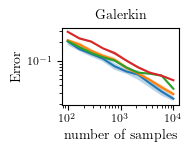

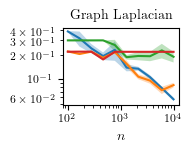

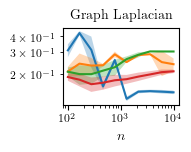

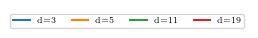

In [96]:
for name in ['galerkin', 'graph_laplacian', 'graph_laplacian_special']:
    if name == 'galerkin':
        df = galerkin_best
    elif name == 'graph_laplacian':
        df = graph_lap_best
    elif name == 'graph_laplacian_special':
        df = graph_lap_special_best

    fig, ax = plt.subplots(1, 1, figsize=(1.5, 1))
    leg = []
    for d in [3, 5, 11, 19]:
        tmp = df[df.d == d]
        a, = ax.plot(tmp.n.values, tmp.error.values)
        ax.fill_between(tmp.n.values, tmp.error - tmp.error_std.values, tmp.error + tmp.error_std.values, alpha=.3)
        ax.loglog()
        leg.append(a)
    if name == 'galerkin':
        ax.set_xlabel('number of samples', fontsize=10)
        ax.set_ylabel('Error', fontsize=10)
        ax.set_title('Galerkin', fontsize=10)
    else:
        ax.set_xlabel('$n$', fontsize=10)
        ax.set_title('Graph Laplacian', fontsize=10)
    fig.savefig(f'{name}_varying_d.pdf', bbox_inches='tight')

fig, ax = plt.subplots(1, 1, figsize=(1, .1))
ax.legend(leg, ['d=3', 'd=5', 'd=11', 'd=19'], fontsize=6, ncol=4)
ax.set_axis_off()
# fig.savefig(f'legend_varying_d.pdf', bbox_inches='tight')

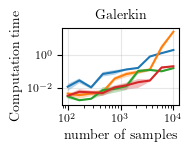

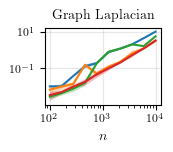

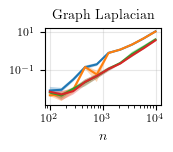

In [97]:
for name in ['galerkin', 'graph_laplacian', 'graph_laplacian_special']:
    if name == 'galerkin':
        df = galerkin_best
    elif name == 'graph_laplacian':
        df = graph_lap_best
    elif name == 'graph_laplacian_special':
        df = graph_lap_special_best

    fig, ax = plt.subplots(1, 1, figsize=(1.5, 1))
    leg = []
    for d in [3, 5, 11, 19]:
        tmp = df[df.d == d]
        a, = ax.plot(tmp.n.values, tmp.time.values)
        ax.fill_between(tmp.n.values, tmp.time - tmp.time_std.values, tmp.time + tmp.time_std.values, alpha=.3)
        ax.loglog()
        leg.append(a)
    if name == 'galerkin':
        ax.set_xlabel('number of samples', fontsize=10)
        ax.set_ylabel('Computation time', fontsize=10)
        ax.set_title('Galerkin', fontsize=10)
    else:
        ax.set_xlabel('$n$', fontsize=10)
        ax.set_title('Graph Laplacian', fontsize=10)
    ax.grid(alpha=.3)
    # fig.savefig(f'{name}_time_varying_d.pdf', bbox_inches='tight')

#### Chechking hyperparameters

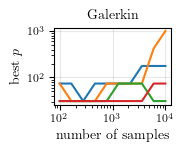

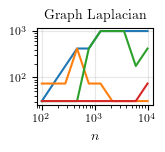

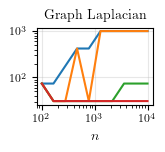

In [98]:
for name in ['galerkin', 'graph_laplacian', 'graph_laplacian_special']:
    if name == 'galerkin':
        df = galerkin_best
    elif name == 'graph_laplacian':
        df = graph_lap_best
    elif name == 'graph_laplacian_special':
        df = graph_lap_special_best

    fig, ax = plt.subplots(1, 1, figsize=(1.5, 1))
    leg = []
    for d in [3, 5, 11, 19]:
        tmp = df[df.d == d]
        a, = ax.plot(tmp.n.values, tmp.p.values)
        ax.loglog()
        leg.append(a)
    if name == 'galerkin':
        ax.set_xlabel('number of samples', fontsize=10)
        ax.set_ylabel('best $p$', fontsize=10)
        ax.set_title('Galerkin', fontsize=10)
    else:
        ax.set_xlabel('$n$', fontsize=10)
        ax.set_title('Graph Laplacian', fontsize=10)
    ax.grid(alpha=.3)
    # fig.savefig(f'{name}_p_varying_d.pdf', bbox_inches='tight')

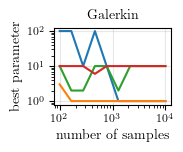

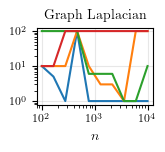

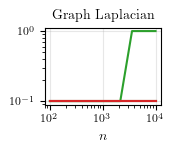

In [99]:
for name in ['galerkin', 'graph_laplacian', 'graph_laplacian_special']:
    if name == 'galerkin':
        df = galerkin_best
    elif name == 'graph_laplacian':
        df = graph_lap_best
    elif name == 'graph_laplacian_special':
        df = graph_lap_special_best

    fig, ax = plt.subplots(1, 1, figsize=(1.5, 1))
    leg = []
    for d in [3, 5, 11, 19]:
        tmp = df[df.d == d]
        a, = ax.plot(tmp.n.values, tmp.kernel_param.values)
        ax.loglog()
        leg.append(a)
    if name == 'galerkin':
        ax.set_xlabel('number of samples', fontsize=10)
        ax.set_ylabel('best parameter', fontsize=10)
        ax.set_title('Galerkin', fontsize=10)
    else:
        ax.set_xlabel('$n$', fontsize=10)
        ax.set_title('Graph Laplacian', fontsize=10)
    ax.grid(alpha=.3)
    # fig.savefig(f'{name}_param_varying_d.pdf', bbox_inches='tight')

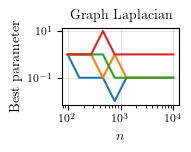

In [101]:
for name in ['graph_laplacian']:
    if name == 'graph_laplacian':
        df = graph_lap_best
    elif name == 'graph_laplacian_special':
        df = graph_lap_special_best

    fig, ax = plt.subplots(1, 1, figsize=(1.5, 1))
    leg = []
    for d in [3, 5, 11, 19]:
        tmp = df[df.d == d]
        a, = ax.plot(tmp.n.values, tmp.graph_laplacian.values)
        ax.loglog()
        leg.append(a)
    ax.set_xlabel('$n$', fontsize=10)
    ax.set_title('Graph Laplacian', fontsize=10)
    ax.set_ylabel('Best parameter', fontsize=10)
    ax.grid(alpha=.3)
    # fig.savefig(f'{name}_param_varying_d.pdf', bbox_inches='tight')

## Computation time

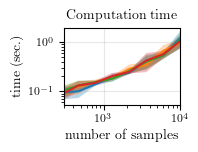

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(1.5, 1))
for name in ['galerkin']:
    if name == 'galerkin':
        tmp = all_runs[(all_runs.kernel_param == 1.) & (all_runs.kernel == 'gaussian') & (all_runs.p == 177) & (all_runs.graph_laplacian == 0)]
        ds = [3, 5, 11, 19]
    elif name == 'graph_laplacian':
        tmp = all_runs[(all_runs.kernel_param == 1.) & (all_runs.kernel == 'gaussian') & (all_runs.p == 177) & (all_runs.graph_laplacian == 1.)]
        ds = [3]
    elif name == 'graph_laplacian_special':
        tmp = all_runs[(all_runs.kernel_param == 1.) & (all_runs.kernel == 'gaussian') & (all_runs.p == 177) & (all_runs.graph_laplacian == -1)]

    key = ['n', 'd']
    df = tmp.groupby(key).mean()['time'].reset_index()
    df['time_std'] = tmp.groupby(key).std()['time'].reset_index()['time']

    leg = []
    for d in ds:
        tmp = df[df.d == d]
        a, = ax.plot(tmp.n.values, tmp.time.values)
        ax.fill_between(tmp.n.values, tmp.time - tmp.time_std.values, tmp.time + tmp.time_std.values, alpha=.3)
        ax.loglog()
        leg.append(a)
    ax.set_xlim(300, 10000)
    ax.set_xlabel('number of samples', fontsize=10)
    ax.set_ylabel('Compute time (s)', fontsize=10)
    ax.set_title('Galerkin', fontsize=10)
    ax.grid(alpha=.3)
    fig.savefig(f'{name}_param_varying_d.pdf', bbox_inches='tight')

In [153]:
tmp.groupby(key).std()['time'].reset_index()[]

(90, 3)

In [142]:
df

n         d 
100       3                                                   0.0
          5                                                   0.0
          7                                                   0.0
          9                                                   0.0
          11                                                  0.0
                                      ...                        
10000     13                                             3.894999
          15                                             4.121347
          17                                             3.921202
          19                                             4.031176
time_std        n      d 
100    3     0.000000
       5     0...
Name: time, Length: 91, dtype: object

In [14]:
galerkin_p = galerkin[galerkin.p == 177].dropna()
graph_lap_p = graph_lap[graph_lap.p == 177].dropna()
graph_lap_special_p = graph_lap_special[graph_lap_special.p == 177].dropna()

## Influence of the kernel
The polynomial kernel is well-specified, gaussian is not. Does it matter?

## Influence of the kernel parameters

## Influence of the number of representer $p$
Does subsampling has a regularization effect?